In [34]:
# PROCESS THE GAIA DR3 RADIAL VELOCITY CATALOG:
# https://gea.esac.esa.int/archive/
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAR 2024 CREATE JUPYTER NOTEBOOK

In [35]:
# **STEPS TO RUN THIS CODE**

# There are two queries you can run to generate this catalog
# The first is a query to grab every star in Gaia with a radial velocity (and a gmag) ~33 million stars
# The second is a query to grab every Gaia star with a radial velocity AND which pass some data quality tests (parallax error) ~29 million stars

# First choose a query, then run it.  
# If you have a decent internet connection and can run the code for hours, the code will execute the query and download the table
# If the code times out, the query results should still be available on your gaia archive account

# Download the data either from the code or from the gaia archive, then run the rest of the processing code.  This can take several hours
# Recommended to download as a vot.gz - this is the smallest file size the gaia server offers
# If any errors occur, consider slicing the data down to the first 1000 rows (data[:1000]) to debug
# Can also add "select TOP 1000" to the query to grab 1000 stars for testing

In [36]:
#This code pulls a catalogue from Gaia DR3 of each star that has a reliable radial velocity
#Based on https://www.aanda.org/articles/aa/full_html/2023/06/aa44220-22/aa44220-22.html#S14,
#We correct radial velocities for stars of high magnitude grvs_mag>11 by Katz et al.
#We also correct stars of high effective temperature 14500>rv_template_teff>8500 and 6>grvs_mag>12 by Blomme et al. as recommended by Katz^

In [37]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table
from astropy.table import QTable
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions

from matplotlib import pyplot as plt, colors

In [38]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia DR3 Radial Velocities'

metadata['catalog'] = 'Gaia Data Release 3: Properties and validation of the radial velocities (Katz et al., 2023)'
metadata['catalog_author'] = 'Katz et al.'
metadata['catalog_year'] = '2023'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'RadialVelocityStars'
metadata['data_group_desc'] = 'Gaia DR3 Radial Velocity'
metadata['data_group_desc_long'] = 'Gaia DR3 Radial Velocity' #need to expand

metadata['fileroot'] = 'gdr3rv'

file_functions.generate_asset_file(metadata)
file_functions.generate_license_file(metadata)

In [39]:
#query the catalogue from Gaia
#https://gea.esac.esa.int/archive/
#The query pulls the source id, positional data, velocity data as well as teff and magnitude for correction purposes
#corrective data included in the query was informed by https://www.aanda.org/articles/aa/full_html/2023/06/aa44220-22/aa44220-22.html#S14

In [40]:
#QUERY #1 - 33 million stars

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in a little over an hour
#file is 3.2 gigabytes, 33,653,049 objects
#Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 source for parallaxes
#job = Gaia.launch_job_async("select a.source_id, a.ra, a.dec, a.pmra, a.pmdec, a.parallax, a.parallax_error, a.phot_g_mean_mag, a.bp_g, a.radial_velocity, a.radial_velocity_error, a.grvs_mag, a.rv_template_teff, "
#                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
#                            "from gaiadr3.gaia_source a left join external.gaiaedr3_distance bj on a.source_id = bj.source_id "
#                            "where a.radial_velocity is not null and a.phot_g_mean_mag > 0 and parallax > 0",
#                            dump_to_file=False)

#Put the resulting table into a Table
#data = job.get_results()
    
#Gaia.remove_jobs(job.jobid) # UNCOMMENT THIS LINE IF YOU WANT TO PURELY READ THE DATA FROM NOTEBOOK CODE - otherwise remember to delete the job from the gaia archive to not clog your memory

#Gaia.logout()

In [41]:
#QUERY #2 - 29 million stars

##### all ## comments are uncommented for the query, all # comments are comments

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in a little over an hour
#file is 2.8 gigabytes, 29,946,388 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 source for parallaxes
job = Gaia.launch_job_async("SELECT TOP 1000 a.source_id, a.ra, a.dec, a.pmra, a.pmdec, a.parallax, a.parallax_error, a.phot_g_mean_mag, a.bp_g, a.radial_velocity, a.radial_velocity_error, a.grvs_mag, a.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.gaia_source a left join external.gaiaedr3_distance bj on a.source_id = bj.source_id "
                            "where a.radial_velocity is not null and a.phot_g_mean_mag > 0 and parallax > 0 and a.parallax / a.parallax_error > 5",
                            dump_to_file=False)

#Put the resulting table into a Table
data = job.get_results()
    
Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1763054894940O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [42]:
#data = Table.read('1761591034536O-result.vot.gz')
#data = Table.read('1761591034536O-result.vot.gz', format='votable')

In [43]:
data

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
3001468183198140800,94.63031223261366,-10.632227248225552,-1.6486698736842267,-0.1971523664224419,4.520102588209706,0.030701878,15.237138,1.0571833,-885.2032,7.120261,13.5555105,3600.0,218.84166,220.28473,217.67738,219.26723,220.85509,217.947
4313545645245332864,286.13948006161826,12.0431615518879,-0.6784563757373283,0.7648214399559667,0.783335824290454,0.027398903,14.897272,0.7446356,-878.91626,7.8022933,--,5500.0,1224.2854,1267.9232,1188.1262,1215.8363,1266.3618,1180.253
4255077877498765696,281.90365531215446,-5.0767822559196665,-2.216158120835281,-2.891394135929329,0.994219806143925,0.037234988,15.591184,0.7768831,-877.84454,12.099504,13.724741,4750.0,966.3308,1001.6573,928.8468,984.2755,1017.2316,952.0411
670746696180987648,121.6770300797143,21.12650542008284,0.600820562000813,2.914811263251899,1.0020618410086095,0.027322844,14.852939,0.3373661,-871.40405,13.431914,13.825596,5750.0,957.37524,978.358,933.14874,956.0024,979.6562,934.2533
4096420376877032832,275.1607033992883,-17.986049065490484,-1.729455964737093,-1.8472151692824714,0.42802607489159167,0.028476719,14.973072,0.7272568,-868.3561,6.8297224,--,5500.0,2138.5398,2249.8118,2034.5579,2122.7952,2256.8945,2011.2017
3416522621408031360,81.63379088038589,24.31181086906121,-5.033458924623354,-7.207386777526891,0.8001010180603059,0.03446635,15.179985,0.7831869,-865.7915,9.46254,13.759079,5500.0,1188.6687,1241.5736,1144.6433,1179.996,1218.1035,1138.503
6144317404055927168,180.0620534171223,-45.74897014619437,-15.989060981963851,4.708122960814848,5.916363112780168,1.0015903,15.307138,0.09589863,-865.0411,5.4992104,--,5750.0,190.35327,229.61697,165.36989,686.35016,844.2047,544.0757
460980974485934976,43.50802837496375,58.38339126701088,-67.77243488517627,18.802238185157428,7.652620204294183,0.035379995,15.6640835,1.4096622,-864.9447,6.814593,13.939033,3500.0,129.88707,130.63493,129.3894,129.81334,130.35837,129.22371


In [44]:
gaia_functions.set_bj_distance(data)

In [45]:
data

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,dcalc,bj_distance,e_bj_dist
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc,,pc,pc
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float64
3001468183198140800,94.63031223261366,-10.632227248225552,-1.6486698736842267,-0.1971523664224419,4.520102588209706,0.030701878,15.237138,1.0571833,-885.2032,7.120261,13.5555105,3600.0,218.84166,220.28473,217.67738,219.26723,220.85509,217.947,2,218.84166,1.3036727905273438
4313545645245332864,286.13948006161826,12.0431615518879,-0.6784563757373283,0.7648214399559667,0.783335824290454,0.027398903,14.897272,0.7446356,-878.91626,7.8022933,--,5500.0,1224.2854,1267.9232,1188.1262,1215.8363,1266.3618,1180.253,1,1215.8363,43.05438232421875
4255077877498765696,281.90365531215446,-5.0767822559196665,-2.216158120835281,-2.891394135929329,0.994219806143925,0.037234988,15.591184,0.7768831,-877.84454,12.099504,13.724741,4750.0,966.3308,1001.6573,928.8468,984.2755,1017.2316,952.0411,1,984.2755,32.59527587890625
670746696180987648,121.6770300797143,21.12650542008284,0.600820562000813,2.914811263251899,1.0020618410086095,0.027322844,14.852939,0.3373661,-871.40405,13.431914,13.825596,5750.0,957.37524,978.358,933.14874,956.0024,979.6562,934.2533,1,956.0024,22.701446533203125
4096420376877032832,275.1607033992883,-17.986049065490484,-1.729455964737093,-1.8472151692824714,0.42802607489159167,0.028476719,14.973072,0.7272568,-868.3561,6.8297224,--,5500.0,2138.5398,2249.8118,2034.5579,2122.7952,2256.8945,2011.2017,1,2122.7952,122.846435546875
3416522621408031360,81.63379088038589,24.31181086906121,-5.033458924623354,-7.207386777526891,0.8001010180603059,0.03446635,15.179985,0.7831869,-865.7915,9.46254,13.759079,5500.0,1188.6687,1241.5736,1144.6433,1179.996,1218.1035,1138.503,1,1179.996,39.80023193359375
6144317404055927168,180.0620534171223,-45.74897014619437,-15.989060981963851,4.708122960814848,5.916363112780168,1.0015903,15.307138,0.09589863,-865.0411,5.4992104,--,5750.0,190.35327,229.61697,165.36989,686.35016,844.2047,544.0757,2,190.35327,32.12354278564453
460980974485934976,43.50802837496375,58.38339126701088,-67.77243488517627,18.802238185157428,7.652620204294183,0.035379995,15.6640835,1.4096622,-864.9447,6.814593,13.939033,3500.0,129.88707,130.63493,129.3894,129.81334,130.35837,129.22371,2,129.88707,0.6227645874023438


In [46]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [47]:
# data quality check
data.remove_rows(np.where(data['dist_pc']<=0)[0])

In [48]:
gaia_functions.get_magnitudes(data)

In [49]:
gaia_functions.get_luminosity(data)

In [50]:
gaia_functions.get_bp_g_color(data) #may want to change to bp_rp

c:\Users\cadem\anaconda3\envs\du_env\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


Freedman–Diaconis number of bins: 36


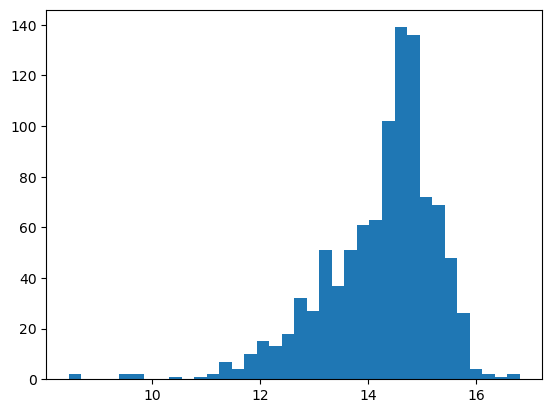

In [51]:
# data check on the G mag
x = data['phot_g_mean_mag']
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins=bins);

In [52]:
#applying corrections from papers
data['radial_velocity_correction'] = [0.0]*len(data)

#Katz correction
katz_indexes = np.where(data['grvs_mag']>11)[0]
data['radial_velocity_correction'][katz_indexes] = [(0.02755*data['grvs_mag'][i]**2 - 0.55863*data['grvs_mag'][i] + 2.81129) for i in katz_indexes]

#Blomme correction
blomme_indexes = np.where((data['grvs_mag']>11)&(data['rv_template_teff']>8500)&(data['rv_template_teff']<14500))[0]
data['radial_velocity_correction'][blomme_indexes] = [7.98 - 1.135*data['grvs_mag'][i] for i in blomme_indexes]

data['corrected_radial_velocity'] = np.subtract(data['radial_velocity'], data['radial_velocity_correction'])
data['corrected_radial_velocity'].unit=u.km/u.s

In [53]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='corrected_radial_velocity', frame='icrs')

In [54]:
data

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,dcalc,bj_distance,e_bj_dist,dist_pc,dist_ly,appmag,absmag,lum,color,radial_velocity_correction,corrected_radial_velocity,x,y,z,u,v,w,speed
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc,,pc,pc,pc,lyr,mag,mag,solLum,solLum,,km / s,pc,pc,pc,km / s,km / s,km / s,
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float64,float32,float32,float32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
3001468183198140800,94.63031223261366,-10.632227248225552,-1.6486698736842267,-0.1971523664224419,4.520102588209706,0.030701878,15.237138,1.0571833,-885.2032,7.120261,13.5555105,3600.0,218.84166,220.28473,217.67738,219.26723,220.85509,217.947,2,218.84166,1.3036727905273438,218.841660,713.8,15.237138,8.536487,0.029882,1.06,0.301139051751687,-885.5043250869079,-166.760957,-134.103992,-45.810203,674.684709,543.277246,183.769566,885.506000
4313545645245332864,286.13948006161826,12.0431615518879,-0.6784563757373283,0.7648214399559667,0.783335824290454,0.027398903,14.897272,0.7446356,-878.91626,7.8022933,--,5500.0,1224.2854,1267.9232,1188.1262,1215.8363,1266.3618,1180.253,1,1215.8363,43.05438232421875,1215.836304,3965.5,14.897272,4.472897,1.261367,0.74,0.0,-878.916259765625,856.771944,860.907016,55.125886,-621.040106,-621.012799,-34.362840,878.936013
4255077877498765696,281.90365531215446,-5.0767822559196665,-2.216158120835281,-2.891394135929329,0.994219806143925,0.037234988,15.591184,0.7768831,-877.84454,12.099504,13.724741,4750.0,966.3308,1001.6573,928.8468,984.2755,1017.2316,952.0411,1,984.2755,32.59527587890625,984.275513,3210.3,15.591184,5.625601,0.436274,0.78,0.3337905341197236,-878.178333991151,868.959746,461.599615,-25.160285,-767.379493,-426.572799,25.504502,878.342825
670746696180987648,121.6770300797143,21.12650542008284,0.600820562000813,2.914811263251899,1.0020618410086095,0.027322844,14.852939,0.3373661,-871.40405,13.431914,13.825596,5750.0,957.37524,978.358,933.14874,956.0024,979.6562,934.2533,1,956.0024,22.701446533203125,956.002380,3118.1,14.852939,4.950644,0.812349,0.34,0.3540000132127834,-871.7580527475878,-803.865430,-311.574597,413.112808,731.843785,295.851171,-370.163166,871.862381
4096420376877032832,275.1607033992883,-17.986049065490484,-1.729455964737093,-1.8472151692824714,0.42802607489159167,0.028476719,14.973072,0.7272568,-868.3561,6.8297224,--,5500.0,2138.5398,2249.8118,2034.5579,2122.7952,2256.8945,2011.2017,1,2122.7952,122.846435546875,2122.795166,6923.6,14.973072,3.338531,3.585811,0.73,0.0,-868.3560791015625,2063.553215,494.595032,-58.165303,-838.214402,-226.193233,30.396381,868.729361
3416522621408031360,81.63379088038589,24.31181086906121,-5.033458924623354,-7.207386777526891,0.8001010180603059,0.03446635,15.179985,0.7831869,-865.7915,9.46254,13.759079,5500.0,1188.6687,1241.5736,1144.6433,1179.996,1218.1035,1138.503,1,1179.996,39.80023193359375,1179.995972,3848.6,15.179985,4.820582,0.915729,0.78,0.3406083174118293,-866.1321122236618,-1172.893592,-33.059005,-124.972863,866.269168,6.295720,46.271783,867.526936
6144317404055927168,180.0620534171223,-45.74897014619437,-15.989060981963851,4.708122960814848,5.916363112780168,1.0015903,15.307138,0.09589863,-865.0411,5.4992104,--,5750.0,190.35327,229.61697,165.36989,686.35016,844.2047,544.0757,2,190.35327,32.12354278564453,190.353271,620.8,15.307138,8.909337,0.021197,0.10,0.0,-865.0410766601562,73.384694,-167.417654,53.107286,-347.354814,755.099118,-240.192078,865.171821
460980974485934976,43.50802837496375,58.38339126701088,-67.77243488517627,18.802238185157428,7.652620204294183,0.035379995,15.6640835,1.4096622,-864.9447,6.814593,13.939033,3500.0,129.88707,130.63493,129.3894,1

<function matplotlib.pyplot.show(close=None, block=None)>

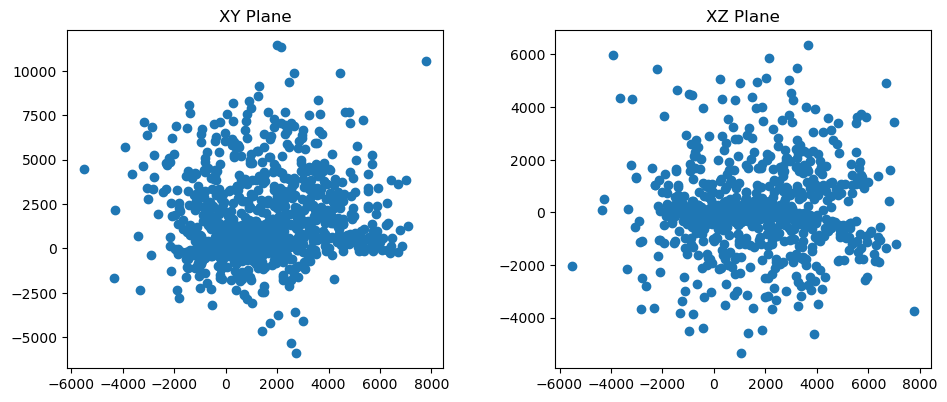

In [55]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

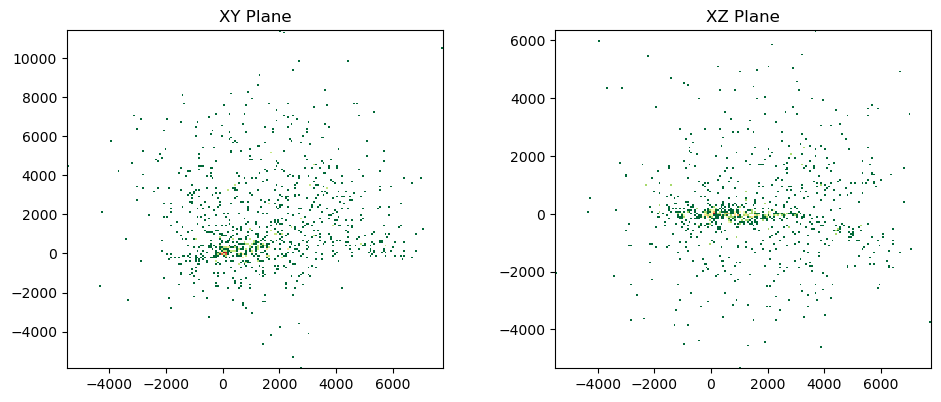

In [56]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [57]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['SOURCE_ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

KeyError: 'source_id'

In [ ]:
data['label'] = ['GaiaDR3_'+ str(source) for source in data['SOURCE_ID']]  #leaving for now in case we want to add other labels

In [ ]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [ ]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

In [ ]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [ ]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [ ]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))